# Load raw data and prepare train set

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import codecs

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import re
import pickle
from tqdm.notebook import tqdm

import nltk

In [2]:
plt.rcParams["figure.figsize"] = (18,9)
plt.style.use('fivethirtyeight')

pd.options.display.max_rows = 400
pd.options.display.max_seq_items = 200
pd.set_option('display.max_colwidth', 200)

## Utility Functions

In [3]:
def remove_return_code(df):
    # Remove return codes
    df['text'] = df['text'].map(lambda x: x.replace('\n','').replace('\r',''))
    # df['contents'] = df['contents'].map(lambda x: re.sub('(\. )(\. )+', '. ', x))

def add_word_count(df):
    df['word_count'] = None
    for i in tqdm(range(len(df))):
        input_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', df["text"][i].lower())
        df['word_count'][i] = len(input_words)

def separate_sections(df):
    df['text_sections'] = None
    for i in range(len(df)):
        df['text_sections'][i] = df['text'][i].split("[SECTION]")
        
def get_statement_date(x):
    if statements.index[0] > x:
        return None
    else:
        for i in range(len(statements)):
            if x <= statements.index[i]:
                return statements.index[i]
        return None

def get_rate_change(x):
    if statements.index[0] > x:
        return None
    else:
        for i in range(len(statements)):
            if x <= statements.index[i]:
                return int(statements['RateChange'][i])
        return None

def get_rate(x):
    if statements.index[0] > x:
        return None
    else:
        for i in range(len(statements)):
            if x <= statements.index[i]:
                return float(statements['Rate'][i])
        return None

In [4]:
def remove_short_section(df, min_words=50):
    for i in tqdm(range(len(df))):
        contents_bk_0 = df["text"][i]
        contents_bk_20 = ""
        df["text"][i] = ""
        for section in df["text_sections"][i]:
            words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', section.lower())
            num_words = len(words)
            if num_words > min_words:
                df["text"][i] += " " + section
            if num_words > 20:
                contents_bk_20 += " " + section
        # Fall back
        if df["text"][i] == "":
            if contents_bk_20 =="":
                df["text"][i] = contents_bk_0
            else:
                df["text"][i] = contents_bk_20

        # Update the word count
        words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', df["text"][i].lower())
        df['word_count'][i] = len(words)


In [5]:
def get_split(text, split_len=150, overlap=50):
    l_total = []
    l_parcial = []
    if len(text.split())//split_len >0:
        n = len(text.split())//split_len
    else: 
        n = 1
    for w in range(n):
        if w == 0:
            l_parcial = text.split()[:(split_len+overlap)]
            l_total.append(" ".join(l_parcial))
        else:
            l_parcial = text.split()[w*split_len:w*split_len + (split_len+overlap)]
            l_total.append(" ".join(l_parcial))
    return l_total

def get_split_df(df, split_len=150, overlap=50):
    split_data_list = []

    for i, row in tqdm(df.iterrows(), desc='Looping dataframe'):
        text_list = get_split(row["text"], split_len, overlap)
        for text in text_list:
            split_data_list.append([row.speaker, text, row.target, row.rate, row.date, row.type])
            
    split_df = pd.DataFrame(split_data_list, columns=['speaker', 'text', 'target', 'rate', 'date', 'type'])
    return split_df
    

In [6]:
def one_hot_encode(df):
    df['target_lower'] = df['target'].apply(lambda x: 1 if x == 0 else 0)
    df['target_hold'] = df['target'].apply(lambda x: 1 if x == 1 else 0)
    df['target_raise'] = df['target'].apply(lambda x: 1 if x == 2 else 0)


## Statements

In [7]:
file = open('../data/FOMC/statement.pickle', 'rb')

statements = pickle.load(file)
file.close()

statements.index.name = 'Date'
statements.head(10)

,contents,speaker,title
Date,,,
1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,Alan Greenspan,statement
1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,Alan Greenspan,statement
1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,Alan Greenspan,statement
1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,Alan Greenspan,statement
1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,Alan Greenspan,statement
1994-11-15,"\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.\n\n[SECTION]\n\nIn a related move, the Federal Op...",Alan Greenspan,statement
1995-02-01,"\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 3/4 percent to 5 1/4 percent, effective immediately.\n\n[SEC...",Alan Greenspan,statement
1995-07-06,\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on bank re...,Alan Greenspan,statement
1995-12-19,\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on reserve...,Alan Greenspan,statement


In [8]:
print(statements.contents[-1])

The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.

[SECTION]

Federal Open Market Committee

[SECTION]

Monetary Policy Principles and Practice

[SECTION]

Policy Implementation

[SECTION]

Reports

[SECTION]

Review of Monetary Policy Strategy, Tools, and Communications

[SECTION]

Institution Supervision

[SECTION]

Reports

[SECTION]

Reporting Forms

[SECTION]

Supervision & Regulation Letters

[SECTION]

Banking Applications & Legal Developments

[SECTION]

Regulatory Resources

[SECTION]

Banking & Data Structure

[SECTION]

Regulations & Statutes

[SECTION]

Payment Policies

[SECTION]

Reserve Bank Payment Services & Data

[SECTION]

Financial Market Utilities & Infrastructures

[SECTION]

Research, Committees, and Forums

[SECTION]

Working Papers and Notes

[SECTION]

Models and Tools

[SECTION]

Bank Assets and Liabilities

[SECTION]

Bank Structure Data

[SECTION]

Business Financ

### Load FED Rate Data
First tried to retrieve from contents, but it was not always accurate.
Thus, load historical FED Rate and match by the dates

Downloaded from FRB of New York (https://apps.newyorkfed.org/markets/autorates/fed%20funds)

In [9]:
# Load FED Target Rates
filename = '../data/MarketData/FEDRates/ffs-01172000-02092020.csv'

fedrates = pd.read_csv(filename, header=0, names=('Date', 'Vol', 'EFFR', '1st','25th' ,'75th' ,'99th' ,'Target' ,'Low' ,'High','Std.' ))
fedrates.index = pd.to_datetime(fedrates.Date, format="%d/%m/%Y")
fedrates.dropna(inplace=True, axis=0, subset=['Date', 'Target'])
fedrates.drop(columns=['Date', 'Vol', 'EFFR', '1st','25th' ,'75th' ,'99th','Low' ,'High','Std.'], inplace=True)

# Separate Range to Low and High
fedrates['Low'] = None
fedrates['High'] = None

for i in range(fedrates.shape[0]):
    target = fedrates['Target'][i]
    if '-' in target:
        fedrates['Low'][i] = re.findall(r'([0-9.]+)-', target)[0]
        fedrates['High'][i] = re.findall(r'-([0-9.]+)', target)[0]
    else:
        (fedrates['Low'][i], fedrates['High'][i]) = (target, target)

fedrates

,Target,Low,High
Date,,,
2020-02-06,1.50-1.75,1.50,1.75
2020-02-05,1.50-1.75,1.50,1.75
2020-02-04,1.50-1.75,1.50,1.75
2020-02-03,1.50-1.75,1.50,1.75
2020-01-31,1.50-1.75,1.50,1.75
2020-01-30,1.50-1.75,1.50,1.75
2020-01-29,1.50-1.75,1.50,1.75
2020-01-28,1.50-1.75,1.50,1.75
2020-01-27,1.50-1.75,1.50,1.75


In [10]:
fedrates.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4925 entries, 2020-02-06 to 2000-07-03
Data columns (total 3 columns):
Target    4925 non-null object
Low       4925 non-null object
High      4925 non-null object
dtypes: object(3)
memory usage: 313.9+ KB


/Users/yuki/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


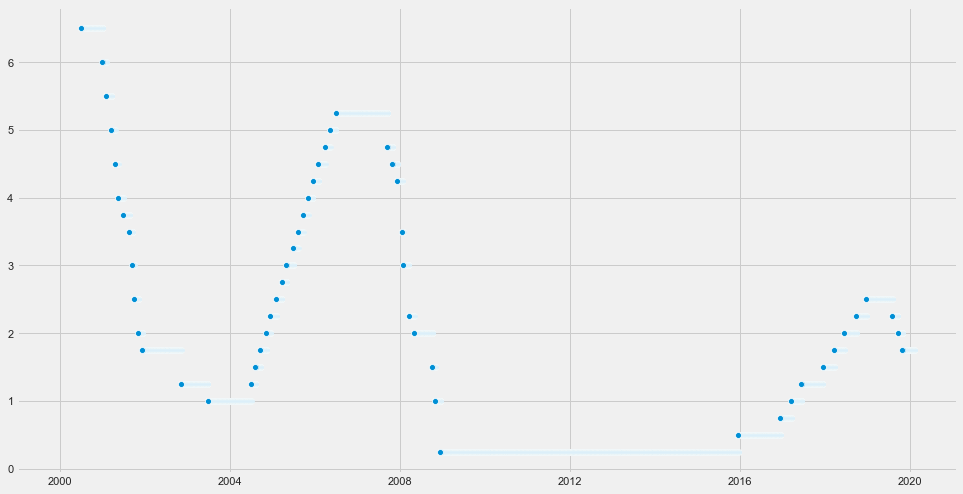

In [11]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot(data=(fedrates["High"].apply(lambda x: float(x))))

Looks good, but FRB of New York has historical data only from 2000.

So, again download from FRB of St. Louis (https://fred.stlouisfed.org/categories/118).

In [12]:
# FRB changed to range from 2008. So use Upper side from 2008.
filename_till08 = '../data/MarketData/FEDRates/DFEDTAR.csv'
filename_from08u = '../data/MarketData/FEDRates/DFEDTARU.csv'
filename_from08l = '../data/MarketData/FEDRates/DFEDTARL.csv'

fedtar = pd.read_csv(filename_till08, names=['Date', 'Rate'], header=0)
fedtaru = pd.read_csv(filename_from08u, names=['Date', 'Rate'], header=0)
fedtarl = pd.read_csv(filename_from08l, names=['Date', 'Rate'], header=0)
fedrate_df = pd.concat([fedtar, fedtaru], axis=0)
fedrate_df.index = pd.to_datetime(fedrate_df.Date, format="%Y-%m-%d")
fedrate_df.drop(columns=['Date'], inplace=True)
fedrate_df['Rate'] = fedrate_df['Rate'].map(lambda x: np.float(x))
fedrate_df

,Rate
Date,
1982-09-27,10.250
1982-09-28,10.250
1982-09-29,10.250
1982-09-30,10.250
1982-10-01,10.000
1982-10-02,10.000
1982-10-03,10.000
1982-10-04,10.000
1982-10-05,10.000


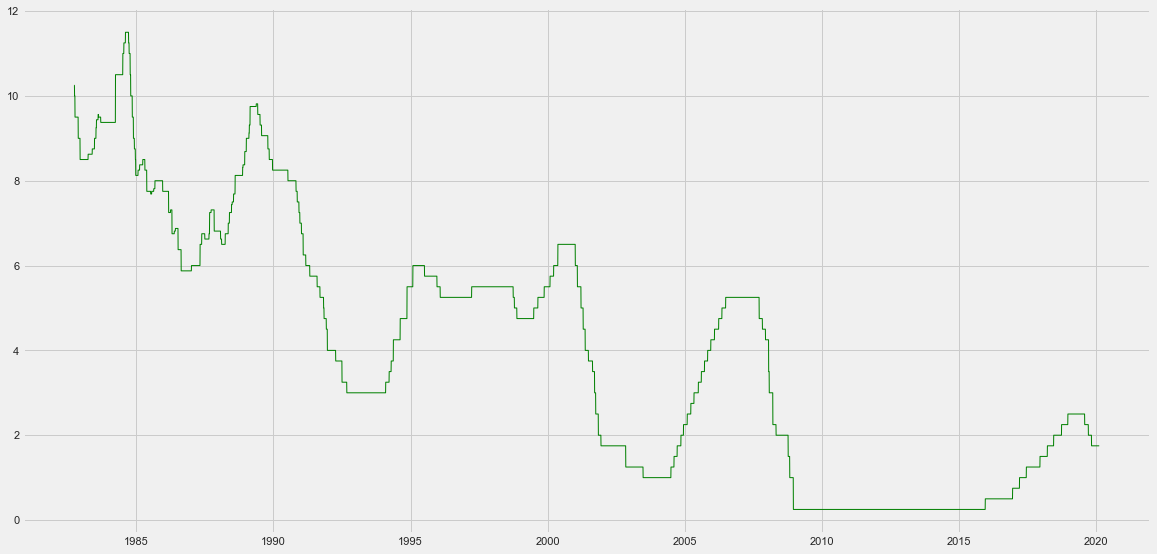

In [13]:
fig, ax = plt.subplots()
ax.plot(fedrate_df.index, fedrate_df['Rate'].values, 
         c = 'green',
         linewidth= 1.0)
ax.grid(True)
plt.show()

In [14]:
fedtaru.tail(300)

,Date,Rate
3775,2019-04-18,2.50
3776,2019-04-19,2.50
3777,2019-04-20,2.50
3778,2019-04-21,2.50
3779,2019-04-22,2.50
3780,2019-04-23,2.50
3781,2019-04-24,2.50
3782,2019-04-25,2.50
3783,2019-04-26,2.50
3784,2019-04-27,2.50


### Map Rate Decisions to Statements

In [15]:
statements['RateChange'] = None
statements['Rate'] = None

for i in range(len(statements)):
    for j in range(len(fedrate_df)):
        if statements.index[i] == fedrate_df.index[j]:
            statements['Rate'][i] = float(fedrate_df['Rate'][j+1])
            if fedrate_df['Rate'][j-1] == fedrate_df['Rate'][j+1]:
                statements['RateChange'][i] = 1
            elif fedrate_df['Rate'][j-1] < fedrate_df['Rate'][j+1]:
                statements['RateChange'][i] = 2
            elif fedrate_df['Rate'][j-1] > fedrate_df['Rate'][j+1]:
                statements['RateChange'][i] = 0

statements.head(10)

,contents,speaker,title,RateChange,Rate
Date,,,,,
1994-02-04,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,Alan Greenspan,statement,2,3.25
1994-03-22,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,Alan Greenspan,statement,2,3.5
1994-04-18,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,Alan Greenspan,statement,2,3.75
1994-05-17,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,Alan Greenspan,statement,2,4.25
1994-08-16,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,Alan Greenspan,statement,2,4.75
1994-11-15,"\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.\n\n[SECTION]\n\nIn a related move, the Federal Op...",Alan Greenspan,statement,2,5.5
1995-02-01,"\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 3/4 percent to 5 1/4 percent, effective immediately.\n\n[SEC...",Alan Greenspan,statement,2,6
1995-07-06,\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on bank re...,Alan Greenspan,statement,0,5.75
1995-12-19,\n\n[SECTION]\n\nFor immediate release\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on reserve...,Alan Greenspan,statement,0,5.5


In [16]:
statements.tail(10)

,contents,speaker,title,RateChange,Rate
Date,,,,,
2019-01-30,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,statement,1,2.5
2019-03-20,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,statement,1,2.5
2019-05-01,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,statement,1,2.5
2019-06-19,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,statement,1,2.5
2019-07-31,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,statement,0,2.25
2019-09-18,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,statement,0,2
2019-10-11,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,statement,1,2
2019-10-30,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,statement,0,1.75
2019-12-11,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Jerome Powell,statement,1,1.75


Looks good.
### Add Quantitative Easing as a Lower event
Between 2008 and 2016 saw zero interest rate. Main monetary measure shifted to quantity from rate. Thus, add "lower" events when those QE was announced.

In [17]:
# Add When QE was first announced on 2008-11-25. No statemenet on that day.
qe_text = "The Federal Reserve announced on Tuesday that it will initiate a program "\
          "to purchase the direct obligations of housing-related government-sponsored "\
          "enterprises (GSEs)--Fannie Mae, Freddie Mac, and the Federal Home Loan Banks "\
          "--and mortgage-backed securities (MBS) backed by Fannie Mae, Freddie Mac, "\
          "and Ginnie Mae.  Spreads of rates on GSE debt and on GSE-guaranteed mortgages "\
          "have widened appreciably of late.  This action is being taken to reduce the cost "\
          "and increase the availability of credit for the purchase of houses, which in turn "\
          "should support housing markets and foster improved conditions in financial markets "\
          "more generally. Purchases of up to $100 billion in GSE direct obligations under "\
          "the program will be conducted with the Federal Reserve's primary dealers through "\
          "a series of competitive auctions and will begin next week.  Purchases of up to "\
          "$500 billion in MBS will be conducted by asset managers selected via a competitive "\
          "process with a goal of beginning these purchases before year-end.  "\
          "Purchases of both direct obligations and MBS are expected to take place over "\
          "several quarters.  Further information regarding the operational details of this "\
          "program will be provided after consultation with market participants."
statements = statements.append(
    pd.Series([qe_text, 'Ben Bernanke', 'statement', 0, 0], index=statements.columns, name=dt.datetime.strptime('2008-11-25', '%Y-%m-%d')),
)
statements.sort_index(inplace=True)

# Add the other times when additional quantitative measures were announced in the statement
statements.loc['2009-03-18', 'RateChange'] = 0 # QE1 Expanded
statements.loc['2010-11-03', 'RateChange'] = 0 # QE2 Announced
statements.loc['2011-09-21', 'RateChange'] = 0 # Operation Twist Announced
statements.loc['2012-06-20', 'RateChange'] = 0 # Operation Twist Extended
statements.loc['2012-09-13', 'RateChange'] = 0 # QE3 Announced
statements.loc['2012-12-12', 'RateChange'] = 0 # QE3 Expanded

# It was announced QE ends
statements.loc['2013-12-18', 'RateChange'] = 2 # Tapering Begines
statements.loc['2014-10-29', 'RateChange'] = 2 # QE3 Terminated
statements.loc['2017-06-14', 'RateChange'] = 2 # Signaled Balance Sheet Normalization
statements.loc['2017-09-20', 'RateChange'] = 2 # Stated Balance Sheet Normalization Begins in Oct

In [18]:
statements.iloc[statements.index > dt.datetime.strptime('2008-11-20', '%Y-%m-%d')]

,contents,speaker,title,RateChange,Rate
Date,,,,,
2008-11-25,"The Federal Reserve announced on Tuesday that it will initiate a program to purchase the direct obligations of housing-related government-sponsored enterprises (GSEs)--Fannie Mae, Freddie Mac, and...",Ben Bernanke,statement,0,0
2008-12-16,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Ben Bernanke,statement,0,0.25
2009-01-28,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Ben Bernanke,statement,1,0.25
2009-03-18,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Ben Bernanke,statement,0,0.25
2009-04-29,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Ben Bernanke,statement,1,0.25
2009-06-24,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Ben Bernanke,statement,1,0.25
2009-08-12,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Ben Bernanke,statement,1,0.25
2009-09-23,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Ben Bernanke,statement,1,0.25
2009-11-04,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Ben Bernanke,statement,1,0.25


## Statements DataFrame

In [19]:
# Reorganize the dataframe
dict = {
    "type": pd.Series(["statement"]*len(statements), index=statements.index),
    "text": statements["contents"],
    "date": statements.index,
    "speaker": statements["speaker"],
    "org_contents": statements["contents"],
    "target": statements["RateChange"],
    "rate": statements["Rate"]
}

statement_df = pd.DataFrame(dict)
statement_df.dropna(subset=['target'], axis=0, inplace=True)

remove_return_code(statement_df)
separate_sections(statement_df)
add_word_count(statement_df)
statement_df.head(10)

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,type,text,date,speaker,org_contents,target,rate,text_sections,word_count
Date,,,,,,,,,
1994-02-04,statement,[SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be assoc...,1994-02-04,Alan Greenspan,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,2,3.25,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated ...",103
1994-03-22,statement,[SECTION]Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be asso...,1994-03-22,Alan Greenspan,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,2,3.5,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated...",42
1994-04-18,statement,[SECTION]Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small ...,1994-04-18,Alan Greenspan,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,2,3.75,"[, Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increa...",39
1994-05-17,statement,[SECTION]The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.[SECTION]The Board approved an increase in th...,1994-05-17,Alan Greenspan,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,2,4.25,"[, The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion., The Board approved an increase in the discount ra...",165
1994-08-16,statement,[SECTION]The Federal Reserve announced today the following monetary policy actions:[SECTION]These measures were taken against the background of evidence of continuing strength in the economic expa...,1994-08-16,Alan Greenspan,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,2,4.75,"[, The Federal Reserve announced today the following monetary policy actions:, These measures were taken against the background of evidence of continuing strength in the economic expansion and hig...",142
1994-11-15,statement,"[SECTION]The Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.[SECTION]In a related move, the Federal Open Market Commit...",1994-11-15,Alan Greenspan,"\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.\n\n[SECTION]\n\nIn a related move, the Federal Op...",2,5.5,"[, The Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately., In a related move, the 

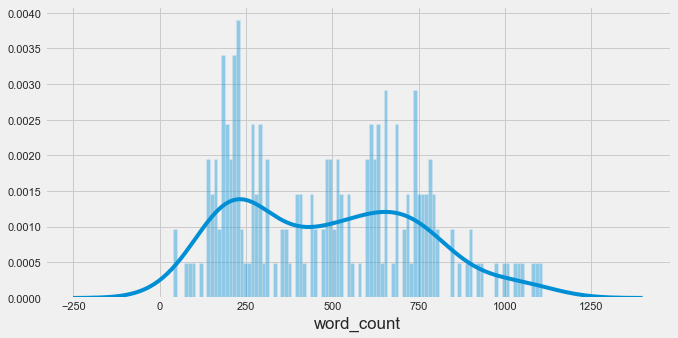

In [20]:
plt.figure(figsize=(10,5))
sns.distplot(statement_df["word_count"], bins=100)

In [21]:
remove_short_section(statement_df)

statement_df.head(10)

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: S

,type,text,date,speaker,org_contents,target,rate,text_sections,word_count
Date,,,,,,,,,
1994-02-04,statement,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated wi...,1994-02-04,Alan Greenspan,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to ...,2,3.25,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated ...",99
1994-03-22,statement,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated w...,1994-03-22,Alan Greenspan,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to...,2,3.5,"[, Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated...",40
1994-04-18,statement,Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase...,1994-04-18,Alan Greenspan,\n\n[SECTION]\n\nChairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with ...,2,3.75,"[, Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increa...",37
1994-05-17,statement,"In taking the discount action, the Board approved requests submitted by the Boards of Directors of eleven Federal Reserve Banks -- Boston, New York, Philadelphia, Richmond, Atlanta, Chicago, St. ...",1994-05-17,Alan Greenspan,\n\n[SECTION]\n\nThe Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion.\n\n[SECTION]\n\nThe Board approved a...,2,4.25,"[, The Federal Reserve today announced two actions designed to maintain favorable trends in inflation and thereby sustain the economic expansion., The Board approved an increase in the discount ra...",57
1994-08-16,statement,"In taking the discount rate action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Kansas City, and Dallas. The disco...",1994-08-16,Alan Greenspan,\n\n[SECTION]\n\nThe Federal Reserve announced today the following monetary policy actions:\n\n[SECTION]\n\nThese measures were taken against the background of evidence of continuing strength in t...,2,4.75,"[, The Federal Reserve announced today the following monetary policy actions:, These measures were taken against the background of evidence of continuing strength in the economic expansion and hig...",51
1994-11-15,statement,"In a related move, the Federal Open Market Committee decided that the increase in the discount rate should be reflected fully in interest rates in reserve markets. These measures were taken again...",1994-11-15,Alan Greenspan,"\n\n[SECTION]\n\nThe Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately.\n\n[SECTION]\n\nIn a related move, the Federal Op...",2,5.5,"[, The Federal Reserve Board today approved an increase in the discount rate from 4 percent to 4 3/4 percent, effective immediately., In a related move, the Feder

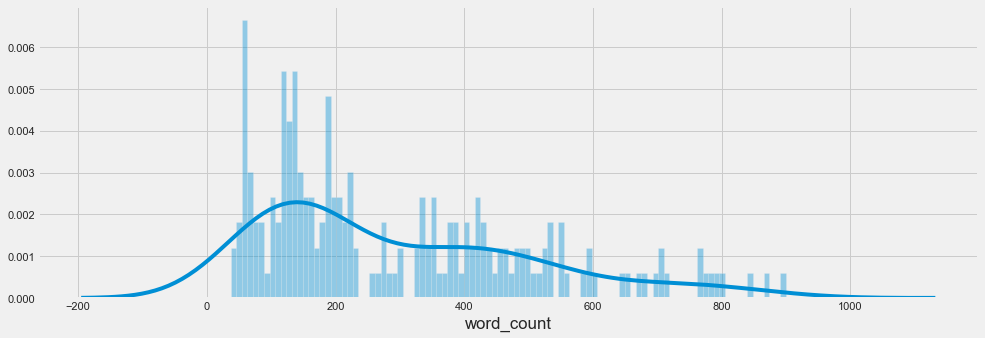

In [22]:
plt.figure(figsize=(15,5))
sns.distplot(statement_df["word_count"], bins=100)

### Split contents to max 200 words

In [23]:
stmt_split_df = get_split_df(statement_df)
stmt_split_df.tail()

,speaker,text,target,rate,date,type
338,Jerome Powell,"market pressures that could adversely affect policy implementation. In addition, the Committee directs the Desk to conduct overnight reverse repurchase operations (and reverse repurchase operation...",1,2.00,2019-10-11,statement
339,Jerome Powell,Information received since the Federal Open Market Committee met in October indicates that the labor market remains strong and that economic activity has been rising at a moderate rate. Job gains ...,0,1.75,2019-10-30,statement
340,Jerome Powell,Information received since the Federal Open Market Committee met in September indicates that the labor market remains strong and that economic activity has been rising at a moderate rate. Job gain...,1,1.75,2019-12-11,statement
341,Jerome Powell,"This action supports the Committee's view that sustained expansion of economic activity, strong labor market conditions, and inflation near the Committee's symmetric 2 percent objective are the mo...",1,1.75,2019-12-11,statement
342,Jerome Powell,Information received since the Federal Open Market Committee met in December indicates that the labor market remains strong and that economic activity has been rising at a moderate rate. Job gains...,1,1.75,2020-01-29,statement


## Minutes DataFrame

In [24]:
file = open('../data/FOMC/minutes.pickle', 'rb')

minutes_df = pickle.load(file)
file.close()

minutes_df.index.name = 'Date'

print(minutes_df.shape)
minutes_df.head()

(224, 3)


,contents,speaker,title
Date,,,
1993-02-03,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Janet Yellen,minutes
1993-03-23,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, March 23, 1993, a...",Alan Greenspan,minutes
1993-05-18,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, May 18, 1993, at ...",Alan Greenspan,minutes
1993-07-07,"A meeting of the Federal Open Market Committee was held in the \r\n offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, July 6, 1993, at 2:3...",Alan Greenspan,minutes
1993-08-17,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System \r\n in Washington, D.C., on Tuesday, August 17, 1993, at ...",Alan Greenspan,minutes


In [25]:
test_text = minutes_df.loc[minutes_df.index == '2009-01-28'].iloc[0, 0]
print(test_text)

January 27-28, 2009

[SECTION]

PRESENT: Mr. Bernanke, ChairmanMr. Dudley, Vice ChairmanMs. DukeMr. EvansMr. KohnMr. LackerMr. Lockhart Mr. WarshMs. Yellen

[SECTION]

Mr. Bullard, Ms. Cumming, Mr. Hoenig, Ms. Pianalto, and Mr. Rosengren, Alternate Members of the Federal Open Market Committee

[SECTION]

Messrs. Fisher, Plosser, and Stern, Presidents of the Federal Reserve Banks of Dallas, Philadelphia, and Minneapolis, respectively

[SECTION]

Messrs. Altig, Clouse, Connors, Kamin, Slifman, Tracy, and Wilcox, Associate Economists

[SECTION]

Ms. Mosser, Temporary Manager, System Open Market Account

[SECTION]

Ms. Johnson,2 Secretary of the Board, Office of the Secretary, Board of Governors

[SECTION]

Mr. Frierson,2 Deputy Secretary, Office of the Secretary, Board of Governors

[SECTION]

Mr. Struckmeyer, Deputy Staff Director, Office of Staff Director for Management, Board of Governors

[SECTION]

Ms. Bailey, Deputy Director, Division of Banking Supervision and Regulation, Board of 

In [26]:
[re.findall("Staff Economic Outlook".lower(), text.lower()) for text in  minutes_df['contents']]

[['staff economic outlook'],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 ['staff economic outlook'],
 ['staff economic outlook'],
 ['staff economic outlook'],
 ['staff economic outlook'],
 ['staff economic outlook'],
 ['staff economic outlook'],
 ['staff economic outlook'],
 ['staff economic outlook'],
 ['staff economic outlook'],
 ['staff economic outlook'],
 ['staff ec

In [27]:
# Reorganize the dataframe
dict = {
    "type": pd.Series(["minutes"]*len(minutes_df), index=minutes_df.index),
    "text": minutes_df["contents"],
    "date": minutes_df.index,
    "speaker": minutes_df["speaker"],
    "org_contents": minutes_df["contents"],
    "target": minutes_df.index.map(get_rate_change),
    "rate": minutes_df.index.map(get_rate)
}

minutes_df = pd.DataFrame(dict)
minutes_df.dropna(subset=['target'], axis=0, inplace=True)

remove_return_code(minutes_df)
separate_sections(minutes_df)
add_word_count(minutes_df)
minutes_df.head(10)

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,type,text,date,speaker,org_contents,target,rate,text_sections,word_count
Date,,,,,,,,,
1994-02-04,minutes,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Thursday, February 3, 1994, at 2:30 p...",1994-02-04,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Thursday, February 3, 1994, a...",2.0,3.25,"[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Thursday, February 3, 1994, at 2:30 ...",10355
1994-03-22,minutes,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, March 22, 1994, at 9:00 a.m.[SEC...",1994-03-22,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \n the offices of the Board of Governors of the Federal Reserve System in \n Washington, D.C., on Tuesday, March 22, 1994, at 9:00 a.m....",2.0,3.50,"[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, March 22, 1994, at 9:00 a.m., P...",6456
1994-03-22,minutes,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, March 22, 1994, at 9:00 a.m.[SEC...",1994-03-22,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \n the offices of the Board of Governors of the Federal Reserve System in \n Washington, D.C., on Tuesday, March 22, 1994, at 9:00 a.m....",2.0,3.50,"[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, March 22, 1994, at 9:00 a.m., P...",6456
1994-05-17,minutes,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, May 17, 1994, at 9:00 a.m.[SECTI...",1994-05-17,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, May 17, 1994, at 9:00 a....",2.0,4.25,"[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, May 17, 1994, at 9:00 a.m., PRE...",4989
1994-07-06,minutes,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., beginning on Tuesday, July 5, 1994, at 2:30 ...",1994-07-06,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., beginning on Tuesday, July 5, 1994, ...",2.0,4.75,"[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., beginning on Tuesday, July 5, 1994, at 2:30...",6736
1994-08-16,minutes,"A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, August 16, 1994, at 9:00 a.m.[S...",1994-08-16,Alan Greenspan,"A meeting of the Federal Open Market Committee was held in \r\n the offices of the Board of Governors of the Federal Reserve System in \r\n Washington, D.C., on Tuesday, August 16, 1994, at 9:00...",2.0,4.75,"[A meeting of the Federal Open Market Committee was held in the offices of the Board of Governors of the Federal Reserve System in Washington, D.C., on Tuesday, August 16, 1994, at 9:00 a.m.,...",

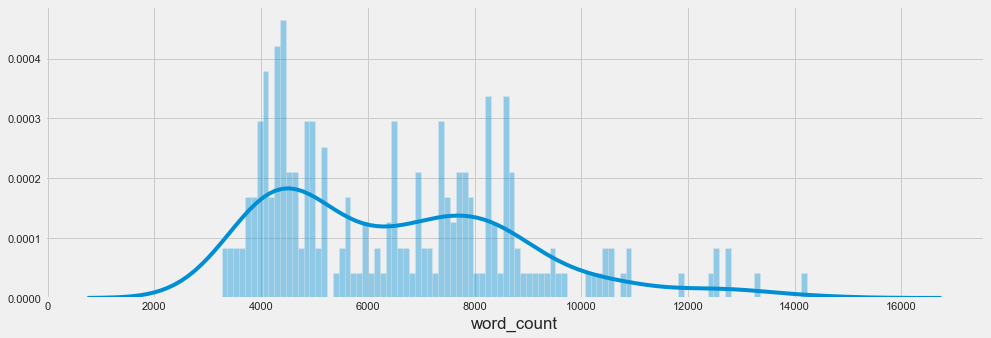

In [28]:
plt.figure(figsize=(15,5))
sns.distplot(minutes_df["word_count"], bins=100)

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


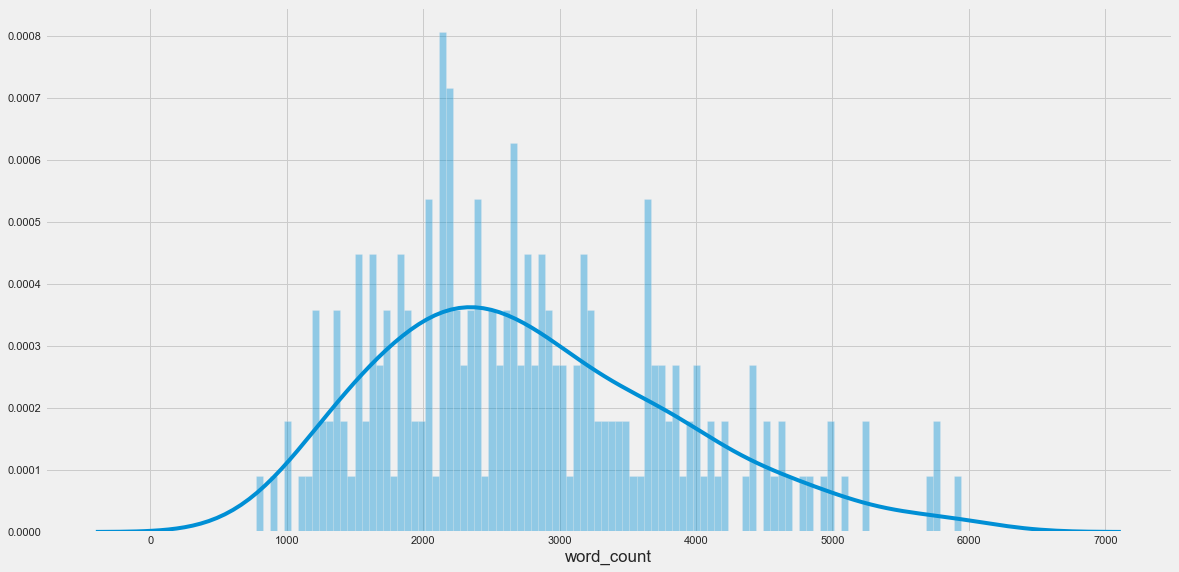

In [29]:
remove_short_section(minutes_df, 150)
sns.distplot(minutes_df["word_count"], bins=100)

In [30]:
print(minutes_df['word_count'])

Date
1994-02-04    3707
1994-03-22    2631
1994-03-22    2631
1994-05-17    2509
1994-07-06    2923
1994-08-16    2128
1994-09-27    2296
1994-11-15    2637
1994-12-20    2698
1995-02-01    4093
1995-03-28    2828
1995-05-23    2131
1995-07-06    3793
1995-08-22    1673
1995-09-26    1626
1995-11-15    2378
1995-12-19    2001
1996-01-30    2822
1996-03-26    1521
1996-05-21    1491
1996-07-02    1959
1996-08-20    1387
1996-09-24    2121
1996-11-13    1742
1996-12-17    1401
1997-02-04    2122
1997-03-25    1291
1997-05-20    1510
1997-07-01    2566
1997-08-19    1360
1997-09-30    1783
1997-11-12    1188
1997-12-16    1318
1998-02-03    2683
1998-03-31    1832
1998-05-19    2415
1998-06-30    2957
1998-08-18    2294
1998-09-29    2410
1998-11-17    2731
1998-12-22    1821
1999-02-02    2851
1999-03-30    2126
1999-05-18    2046
1999-06-29    2775
1999-08-24    3124
1999-10-05    1636
1999-11-16    2422
1999-12-21    2195
2000-02-02    2849
2000-03-21    1589
2000-05-16    1917
2000-06

### Split contents to max 200 words

In [31]:
minutes_split_df = get_split_df(minutes_df)
minutes_split_df.tail()

,speaker,text,target,rate,date,type
3866,Jerome Powell,"at U.S. banks were quite high relative to other sectors of the financial system, raising questions about the potential migration of lending activities away from the U.S. banking sector to areas ou...",1.0,1.75,2020-01-29,minutes
3867,Jerome Powell,"With regard to the Committee's maximum employment objective, a few participants observed that the actual level of employment might still be below maximum employment and that maintaining the presen...",1.0,1.75,2020-01-29,minutes
3868,Jerome Powell,observed that enactment of this plan had succeeded in replenishing reserve balances to levels at or above those prevailing in early September 2019 and in ensuring continued control of the federal ...,1.0,1.75,2020-01-29,minutes
3869,Jerome Powell,to communicate to the public that open market operations now and in the period ahead were technical operations aimed at achieving and maintaining ample reserves and that any adjustments to those o...,1.0,1.75,2020-01-29,minutes
3870,Jerome Powell,Committee directs the Desk to continue purchasing Treasury bills at least into the second quarter of 2020 to maintain over time ample reserve balances at or above the level that prevailed in early...,1.0,1.75,2020-01-29,minutes


## Script DataFrame
Press Conference transcripts are available only from 2011

In [32]:
file = open('../data/FOMC/script.pickle', 'rb')

script_df = pickle.load(file)
file.close()

script_df.index.name = 'Date'
print(script_df.shape)
script_df.head()

(40, 3)


,contents,speaker,title
Date,,,
2011-04-27,"CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl...",Ben Bernanke,Press Conference Transcript
2011-06-22,"CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ...",Ben Bernanke,Press Conference Transcript
2011-11-02,"CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take...",Ben Bernanke,Press Conference Transcript
2012-01-25,CHAIRMAN BERNANKE. Good afternoon. Earlier today the Federal Open Market Committee (FOMC) approved new measures to support the recovery and employment growth. I’ll get to the specifics of our a...,Ben Bernanke,Press Conference Transcript
2012-04-25,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...,Ben Bernanke,Press Conference Transcript


In [33]:
print(script_df['contents'][2])

CHAIRMAN BERNANKE.  Good afternoon, everybody.  Welcome.  In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy.  I will then be glad to take your questions.   As indicated in its statement, the Committee decided today to maintain the policies that were initiated at previous meetings.  In particular, the Committee is keeping the target range for the federal funds rate at 0 to ¼ percent and continues to anticipate that economic conditions are likely to warrant exceptionally low levels for the federal funds rate at least through mid-2013. The Committee will continue the program that we announced in September to extend the average maturity of the Federal Reserve’s holdings of securities by purchasing longer-term Treasury securities and selling an equal amount of shorter-term Treasury securities.  Our purchases of longer-term securities exert downward pressures on longer-term interest rates; at the same time, our guidance about the lik

In [34]:
# Reorganize the dataframe
dict = {
    "type": pd.Series(["script"]*len(script_df), index=script_df.index),
    "text": script_df["contents"],
    "date": script_df.index,
    "speaker": script_df["speaker"],
    "org_contents": script_df["contents"],
    "target": script_df.index.map(get_rate_change),
    "rate": script_df.index.map(get_rate)
}

script_df = pd.DataFrame(dict)
script_df.dropna(subset=['target'], axis=0, inplace=True)

script_df.head(10)

,type,text,date,speaker,org_contents,target,rate
Date,,,,,,,
2011-04-27,script,"CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl...",2011-04-27,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl...",1,0.25
2011-06-22,script,"CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ...",2011-06-22,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks today, I’ll briefly review today’s policy decision. And I’ll place the decision in the context of our economic projections ...",1,0.25
2011-11-02,script,"CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take...",2011-11-02,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon, everybody. Welcome. In my opening remarks, I will briefly review today’s policy decision of the Federal Open our policy strategy. I will then be glad to take...",1,0.25
2012-01-25,script,CHAIRMAN BERNANKE. Good afternoon. Earlier today the Federal Open Market Committee (FOMC) approved new measures to support the recovery and employment growth. I’ll get to the specifics of our a...,2012-01-25,Ben Bernanke,CHAIRMAN BERNANKE. Good afternoon. Earlier today the Federal Open Market Committee (FOMC) approved new measures to support the recovery and employment growth. I’ll get to the specifics of our a...,1,0.25
2012-04-25,script,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...,2012-04-25,Ben Bernanke,CHAIRMAN BERNANKE. Good afternoon and welcome. In my opening remarks I will briefly review today’s policy decision by the Federal Open to you regarding the Committee’s longer-run policy goals a...,1,0.25
2012-06-20,script,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in th...",2012-06-20,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then I’ll place the Committee’s policy decision in th...",0,0.25
2012-09-13,script,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then place the Committee’s appropriate path of moneta...",2012-09-13,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon. Before we get to questions, I’ll summarize today’s policy action by the Federal Open Market Committee and then place the Committee’s appropriate path of moneta...",0,0.25
2012-12-12,script,"CHAIRMAN BERNANKE. Good afternoon. It’s been about three and a half years since the economic recovery began. The economy continues to expand at a moderate pace. Unfortunately, however, unemploy...",2012-12-12,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon. It’s been about three and a half years since the economic recovery began. The economy continues to expand at a moderate pace. Unfortunately, however, unemploy...",0,0.25
2013-03-20,script,"CHAIRMAN BERNANKE. Good afternoon. The Federal Open Market Committee concluded a two-day meeting earlier today. As always, my colleagues and I reviewed recent economic and financial developmen...",2013-03-20,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon. The Federal Open Market Committee concluded a two-day meeting earlier today. As always, my collea

### Split by speakers
Scripts contains words from different people, so split by the speaker

In [35]:
print(script_df.text[0])

CHAIRMAN BERNANKE.  Good afternoon.  Welcome.  In my opening remarks, I’d like to briefly first review today’s policy decision.  I’ll then turn next to the Federal Open Market Committee’s quarterly economic projections also being released today, and I’ll place today’s policy decision in the context of the Committee’s projections and the Federal Reserve’s statutory mandate to foster maximum employment and price stability.  I’ll then be glad to take your questions.  Throughout today’s briefing, my goal will be to reflect the consensus of the Committee, while taking note of the diversity of views as appropriate.  Of course, my remarks and interpretations are my own responsibility.   In its policy statement released earlier today, the Committee announced, first, that it is maintaining its existing policy of reinvesting principal payments from its security holdings, and, second, that it will complete its planned purchases of $600 billion of longer-term Treasury securities by the end of the 

In [36]:
script_data_list = []

for i, row in tqdm(script_df.iterrows(), desc='Looping dataframe'):
    text_list = row["text"].split("\n\n[SECTION]\n\n")
    for text in text_list:
        match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d? (.*)', text)
        if len(match) == 0:
            match = re.findall(r'(^[A-Za-zŞ. ]*[A-Z]{3}).\d(.*)', text)
            if len(match) == 0:
                print("not matched: ", text)
                print(row['date'])
                print()
        if len(match) == 1:
            speaker, content = match[0]
            script_data_list.append([row.type, content, row.date, speaker, text, row.target, row.rate, ""])        
            
script_speaker_df = pd.DataFrame(script_data_list, columns=['type', 'text', 'date', 'speaker', 'org_contents', 'target', 'rate', 'text_sections'])

In [37]:
add_word_count(script_speaker_df)
separate_sections(script_speaker_df)
script_speaker_df.head()

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,type,text,date,speaker,org_contents,target,rate,text_sections,word_count
0,script,"Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic projecti...",2011-04-27,CHAIRMAN BERNANKE,"CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl...",1,0.25,"[ Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic project...",1582
1,script,"Mr. Chairman, tomorrow we’re going to get a pretty weak first-quarter GDP number. Your own projections for the year have been downgraded in this meeting. How—first of all, what do you see as th...",2011-04-27,QUESTION,"QUESTION. Mr. Chairman, tomorrow we’re going to get a pretty weak first-quarter GDP number. Your own projections for the year have been downgraded in this meeting. How—first of all, what do you...",1,0.25,"[ Mr. Chairman, tomorrow we’re going to get a pretty weak first-quarter GDP number. Your own projections for the year have been downgraded in this meeting. How—first of all, what do you see as t...",64
2,script,"You’re correct. We haven’t seen the GDP number yet. But we, like most private-sector forecasters, are expecting a relatively weak number for the first quarter, maybe something a little under 2 ...",2011-04-27,CHAIRMAN BERNANKE,"CHAIRMAN BERNANKE. You’re correct. We haven’t seen the GDP number yet. But we, like most private-sector forecasters, are expecting a relatively weak number for the first quarter, maybe somethin...",1,0.25,"[ You’re correct. We haven’t seen the GDP number yet. But we, like most private-sector forecasters, are expecting a relatively weak number for the first quarter, maybe something a little under 2...",191
3,script,"Mr. Chairman, given what you know about the pace of the economy now, what is your best guess for how soon the Fed needs to begin to withdraw its extraordinary stimulus for the economy? And could...",2011-04-27,QUESTION,"QUESTION. Mr. Chairman, given what you know about the pace of the economy now, what is your best guess for how soon the Fed needs to begin to withdraw its extraordinary stimulus for the economy? ...",1,0.25,"[ Mr. Chairman, given what you know about the pace of the economy now, what is your best guess for how soon the Fed needs to begin to withdraw its extraordinary stimulus for the economy? And coul...",56
4,script,"Well, currently as the statement suggests, we are in a moderate recovery. We’ll be looking very carefully, first, to see if that recovery is, indeed, sustainable, as we believe it is. And we’ll...",2011-04-27,CHAIRMAN BERNANKE,"CHAIRMAN BERNANKE. Well, currently as the statement suggests, we are in a moderate recovery. We’ll be looking very carefully, first, to see if that recovery is, indeed, sustainable, as we believ...",1,0.25,"[ Well, currently as the statement suggests, we are in a moderate recovery. We’ll be looking very carefully, first, to see if that recovery is, indeed, sustainable, as we believe it is. And we’l...",315


(1893, 9)


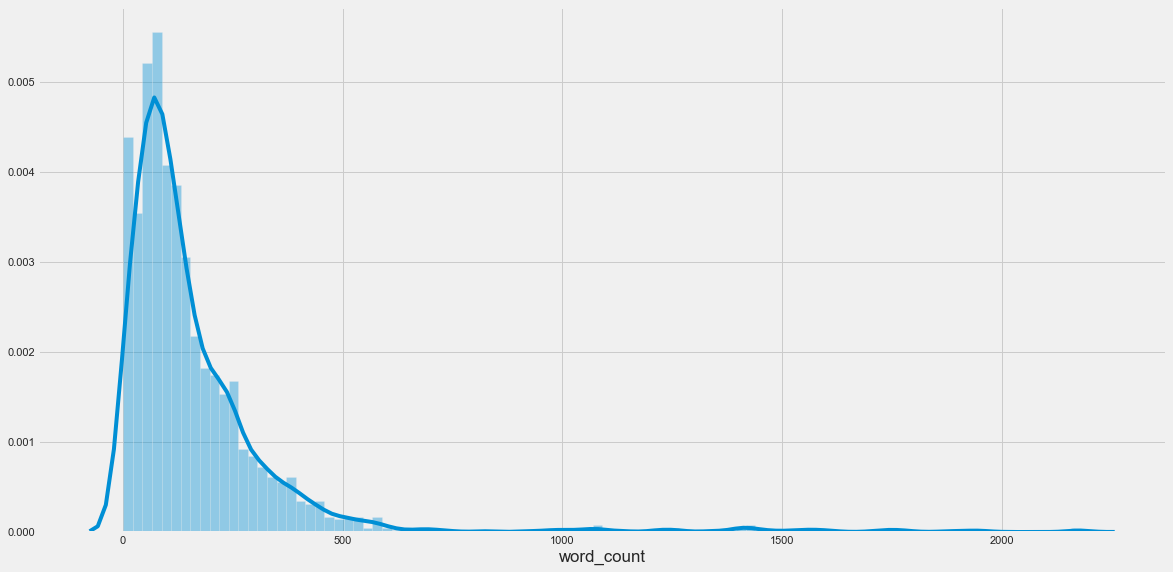

In [38]:
print(script_speaker_df.shape)
sns.distplot(script_speaker_df["word_count"], bins=100)

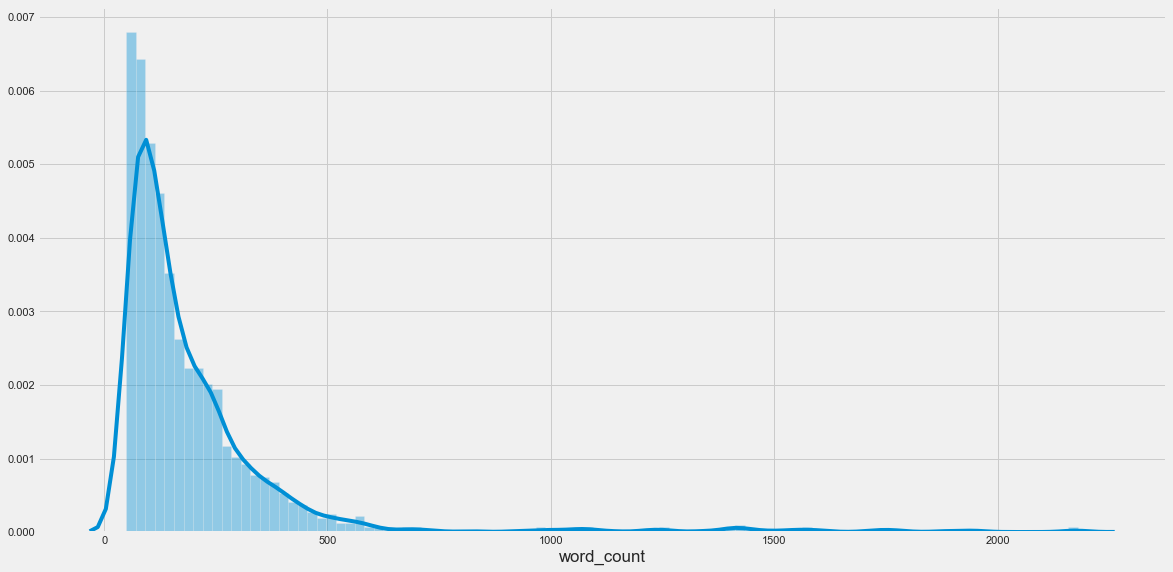

In [39]:
for i, row in tqdm(script_speaker_df.iterrows()):
    if row['word_count'] < 50:
        script_speaker_df.drop([i], axis=0, inplace=True)

sns.distplot(script_speaker_df["word_count"], bins=100)

In [40]:
script_speaker_df.shape

(1519, 9)

In [41]:
# script_speaker_df[script_speaker_df['speaker'].str.contains("GREENSPAN|YELLEN|BERNANKE|POWELL")]

# Scripts are from 2011, so Greenspan's scripts are not avialable.
# script_greenspan = script_speaker_df[script_speaker_df['speaker'].str.contains("GREENSPAN")]
# script_greenspan['speaker'] = 'Alan Greenspan'

script_bernanke = script_speaker_df[script_speaker_df['speaker'].str.contains("BERNANKE")]
script_bernanke['speaker'] = 'Ben Bernanke'
print(script_bernanke.shape)

script_yellen = script_speaker_df[script_speaker_df['speaker'].str.contains("YELLEN")]
script_yellen['speaker'] = 'Janet Yellen'
print(script_yellen.shape)

script_powell = script_speaker_df[script_speaker_df['speaker'].str.contains("POWELL")]
script_powell['speaker'] = 'Jerome Powell'
print(script_powell.shape)

script_gbyp_df = pd.concat([script_bernanke, script_yellen, script_powell], ignore_index=True)

(274, 9)
(281, 9)
(343, 9)


/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [42]:
script_bernanke

,type,text,date,speaker,org_contents,target,rate,text_sections,word_count
0,script,"Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic projecti...",2011-04-27,Ben Bernanke,"CHAIRMAN BERNANKE. Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterl...",1,0.25,"[ Good afternoon. Welcome. In my opening remarks, I’d like to briefly first review today’s policy decision. I’ll then turn next to the Federal Open Market Committee’s quarterly economic project...",1582
2,script,"You’re correct. We haven’t seen the GDP number yet. But we, like most private-sector forecasters, are expecting a relatively weak number for the first quarter, maybe something a little under 2 ...",2011-04-27,Ben Bernanke,"CHAIRMAN BERNANKE. You’re correct. We haven’t seen the GDP number yet. But we, like most private-sector forecasters, are expecting a relatively weak number for the first quarter, maybe somethin...",1,0.25,"[ You’re correct. We haven’t seen the GDP number yet. But we, like most private-sector forecasters, are expecting a relatively weak number for the first quarter, maybe something a little under 2...",191
4,script,"Well, currently as the statement suggests, we are in a moderate recovery. We’ll be looking very carefully, first, to see if that recovery is, indeed, sustainable, as we believe it is. And we’ll...",2011-04-27,Ben Bernanke,"CHAIRMAN BERNANKE. Well, currently as the statement suggests, we are in a moderate recovery. We’ll be looking very carefully, first, to see if that recovery is, indeed, sustainable, as we believ...",1,0.25,"[ Well, currently as the statement suggests, we are in a moderate recovery. We’ll be looking very carefully, first, to see if that recovery is, indeed, sustainable, as we believe it is. And we’l...",315
6,script,"Thanks, Steve. First, I should start by saying that the Secretary of the Treasury, of course, is the spokesperson for U.S. policy on the dollar and Secretary Geithner had some words yesterday. ...",2011-04-27,Ben Bernanke,"CHAIRMAN BERNANKE. Thanks, Steve. First, I should start by saying that the Secretary of the Treasury, of course, is the spokesperson for U.S. policy on the dollar and Secretary Geithner had some...",1,0.25,"[ Thanks, Steve. First, I should start by saying that the Secretary of the Treasury, of course, is the spokesperson for U.S. policy on the dollar and Secretary Geithner had some words yesterday. ...",207
8,script,"Well, the dollar—the dollar fluctuates. One factor, for example, that has caused fluctuations that have been quite extreme during the crisis has been the safe-haven effect. So, for example, dur...",2011-04-27,Ben Bernanke,"CHAIRMAN BERNANKE. Well, the dollar—the dollar fluctuates. One factor, for example, that has caused fluctuations that have been quite extreme during the crisis has been the safe-haven effect. S...",1,0.25,"[ Well, the dollar—the dollar fluctuates. One factor, for example, that has caused fluctuations that have been quite extreme during the crisis has been the safe-haven effect. So, for example, du...",167
10,script,"Sure. Thanks, Jon. So, first of all, gasoline prices obviously have risen quite significantly. And we, of course, are watching that carefully, that higher gas prices are absolutely creating a ...",2011-04-27,Ben Bernanke,"CHAIRMAN BERNANKE. Sure. Thanks, Jon. So, first of all, gasoline prices obviously have risen quite significantly. And we, of course, are watching that carefully, that higher gas prices are abs...",1,0.25,"[ Sure. Thanks, Jon. So, first of all, gasoline prices obviously have risen quite significantly. And we, of course, are watching that carefully, that higher gas prices are absolutely creating a...",497
12,script,"Well, as I mentioned, we’ve made a lot of progress. Last moderat

Before:  (898, 9)



After (40, 9)


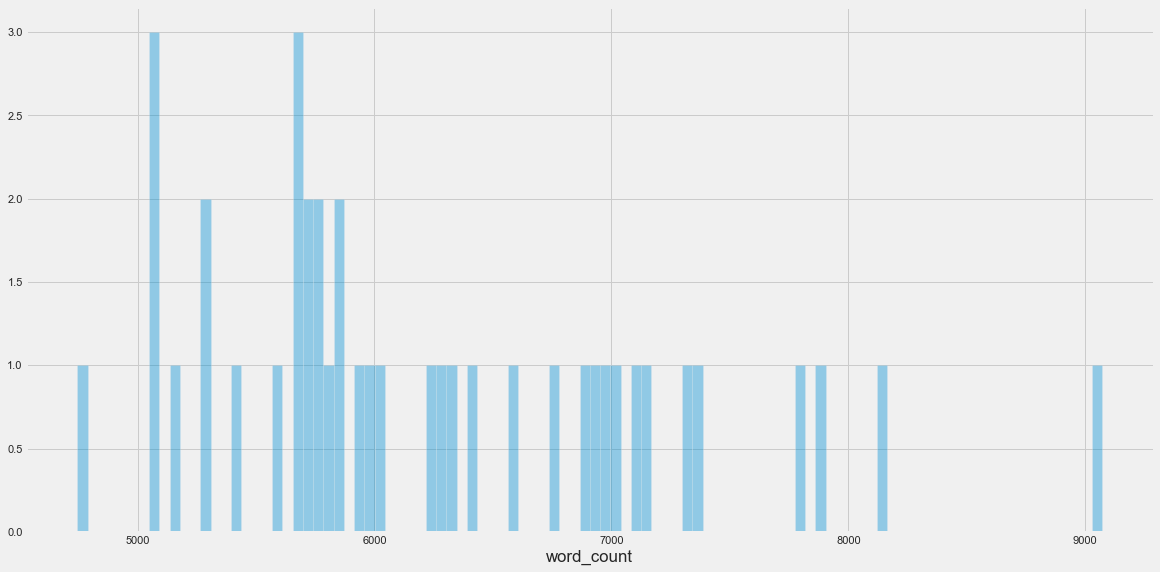

In [43]:
# Combine scripts
tmp_date = ''
tmp_speaker = ''
tmp_data = []

print('Before: ', script_gbyp_df.shape)

for i, row in tqdm(script_gbyp_df.iterrows()):
    if row.date == tmp_date and row.speaker == tmp_speaker:
        tmp_data[-1]['text'] += row.text
        tmp_data[-1]['org_contents'] += row.org_contents
        tmp_data[-1]['word_count'] += row.word_count
    else:
        tmp_date = row.date
        tmp_speaker = row.speaker
        tmp_data.append(row)

script_gbyp_combined_df = pd.DataFrame(tmp_data)

print('After', script_gbyp_combined_df.shape)
script_gbyp_combined_df.head()

sns.distplot(script_gbyp_combined_df['word_count'], bins=100, kde=False)

### Split contents to max 200 words

In [44]:
script_split_df = get_split_df(script_gbyp_combined_df)
print(script_split_df.shape)
script_split_df.tail()


(1590, 6)


,speaker,text,target,rate,date,type
1585,Jerome Powell,certainty about—about what does and doesn’t qualify and that sort of thing. The law can both be more effective and more efficient is—it comes down to. And we think this is a good way. It’s also ju...,1,1.75,2020-01-29,script
1586,Jerome Powell,"to get to agreement with the OCC, really. So we haven’t made any In terms of, you know—Governor Brainard led our oversight committee over these activities for many years, and I asked her to take t...",1,1.75,2020-01-29,script
1587,Jerome Powell,"brighter lines to define our LISCC supervisory portfolio, which we haven’t really had to date. Remember that when a firm moves from one portfolio to another, that doesn’t mean that its level of sc...",1,1.75,2020-01-29,script
1588,Jerome Powell,"ask you a question about the—one of the unintended consequences over the years-long low interest rate environment, and that is that savers haven’t gotten as much return as would have otherwise bee...",1,1.75,2020-01-29,script
1589,Jerome Powell,"that just is the effect of lower interest rates. So, if—so many, many people benefit from low interest rates. In fact, you don’t hear—when you talk to the low- and moderate-income communities, one...",1,1.75,2020-01-29,script


## Speech DataFrame

In [45]:
file = open('../data/FOMC/speech.pickle', 'rb')

speech_df = pickle.load(file)
file.close()

speech_df.index.name = 'Date'
print(speech_df.shape)
speech_df

(1455, 3)


,contents,speaker,title
Date,,,
1996-06-13,"Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\...",Chairman Alan Greenspan,Bank supervision in a world economy
1996-06-18,"Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i...","Governor Edward W. Kelley, Jr.",Developments in electronic money and banking
1996-09-08,Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...,Governor Laurence H. Meyer,Monetary policy objectives and strategy
1996-09-19,"Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1...",Chairman Alan Greenspan,Regulation and electronic payment systems
1996-10-02,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S...",Governor Lawrence B. Lindsey,Small business is big business
1996-10-05,"Remarks by Chairman Alan Greenspan\nBank supervision, regulation, and risk\r\nAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii \r\nOctober 5, 1996\n\n[SECTION]\n\n\n\...",Chairman Alan Greenspan,"Bank supervision, regulation, and risk"
1996-10-07,"Remarks by Chairman Alan Greenspan\nU.S. Treasury securities market: Lessons from Alexander Hamilton\r\nAt the Annual Public Service Awards Dinner of the Public Securities Association, New York, N...",Chairman Alan Greenspan,U.S. Treasury securities market: Lessons from Alexander Hamilton
1996-10-09,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Community Development Lending Conference, Dallas, Texas\r\nOctober 9, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nHere We Go Again?\n\n[SECTION]\n\nThan...",Governor Lawrence B. Lindsey,Here we go again?
1996-10-11,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Atlantic Economic Society, Washington, D.C.\r\nOctober 11, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nHow To Grow Faster\n\n[SECTION]\n\nIt is my pleas...",Governor Lawrence B. Lindsey,How to grow faster


In [46]:
# Reorganize the dataframe
dict = {
    "type": ["speech"]*len(speech_df),
    "text": speech_df["contents"],
    "date": speech_df.index,
    "speaker": speech_df["speaker"],
    "org_contents": speech_df["contents"],
    "target": speech_df.index.map(get_rate_change),
    "rate": speech_df.index.map(get_rate)
}

tmp_speech_df = pd.DataFrame(dict)
tmp_speech_df.reset_index(drop=True, inplace=True)
tmp_speech_df.dropna(subset=['target'], axis=0, inplace=True)

tmp_speech_df.head(10)

,type,text,date,speaker,org_contents,target,rate
0,speech,"Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\...",1996-06-13,Chairman Alan Greenspan,"Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\...",2.0,5.5
1,speech,"Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i...",1996-06-18,"Governor Edward W. Kelley, Jr.","Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i...",2.0,5.5
2,speech,Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...,1996-09-08,Governor Laurence H. Meyer,Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...,2.0,5.5
3,speech,"Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1...",1996-09-19,Chairman Alan Greenspan,"Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1...",2.0,5.5
4,speech,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S...",1996-10-02,Governor Lawrence B. Lindsey,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S...",2.0,5.5
5,speech,"Remarks by Chairman Alan Greenspan\nBank supervision, regulation, and risk\r\nAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii \r\nOctober 5, 1996\n\n[SECTION]\n\n\n\...",1996-10-05,Chairman Alan Greenspan,"Remarks by Chairman Alan Greenspan\nBank supervision, regulation, and risk\r\nAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii \r\nOctober 5, 1996\n\n[SECTION]\n\n\n\...",2.0,5.5
6,speech,"Remarks by Chairman Alan Greenspan\nU.S. Treasury securities market: Lessons from Alexander Hamilton\r\nAt the Annual Public Service Awards Dinner of the Public Securities Association, New York, N...",1996-10-07,Chairman Alan Greenspan,"Remarks by Chairman Alan Greenspan\nU.S. Treasury securities market: Lessons from Alexander Hamilton\r\nAt the Annual Public Service Awards Dinner of the Public Securities Association, New York, N...",2.0,5.5
7,speech,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Community Development Lending Conference, Dallas, Texas\r\nOctober 9, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nHere We Go Again?\n\n[SECTION]\n\nThan...",1996-10-09,Governor Lawrence B. Lindsey,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Community Development Lending Conference, Dallas, Texas\r\nOctober 9, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nHere We Go Again?\n\n[SECTION]\n\nThan...",2.0,5.5
8,speech,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Atlantic Economic Society, Washington, D.C.\r\nOctober 11, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nHow To Grow Faster\n\n[SECTION]\n\nIt is my pleas...",1996-10-11,Governor Lawrence B. Lindsey,"Remarks by Governor Lawrence B. Lin

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


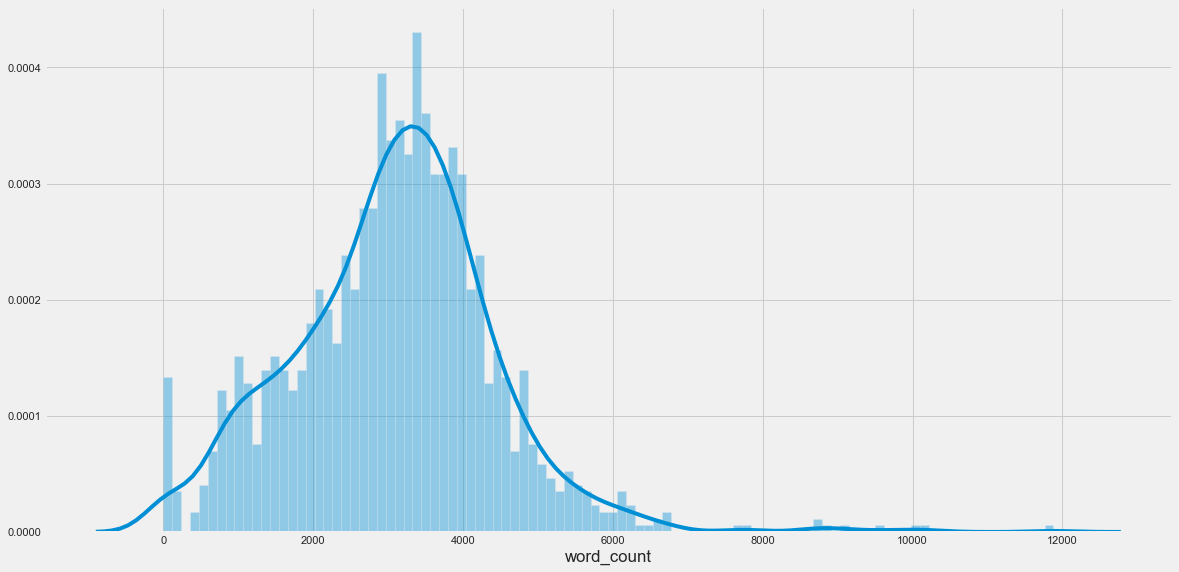

In [47]:
add_word_count(tmp_speech_df)
separate_sections(tmp_speech_df)
sns.distplot(tmp_speech_df["word_count"], bins=100)

In [48]:
#print(speech_df['org_contents'][1000])
#print(speech_df['text'][1000])

In [49]:
# Keep only those having key words and longer than a certain length
num_keep, num_drop = 0, 0
keywords = ['rate', 'rates']

for i, row in tqdm(tmp_speech_df.iterrows(), desc='Looping Speech DataFrame'):
    new_text = ''
    text_list = row["text"].split("\n\n[SECTION]\n\n")
    for text in text_list:
        text_words = re.findall(r'\b([a-zA-Z]+n\'t|[a-zA-Z]+\'s|[a-zA-Z]+)\b', text.lower())
        if len(text_words) > 50 and len(set(text_words).intersection(keywords)) > 0:
            new_text += '\n\n' + text
            num_keep += 1
        else:
            num_drop += 1
    if new_text == '':
        tmp_speech_df.drop([i], axis=0, inplace=True)
    else:
        tmp_speech_df['text'][i] = new_text

print("Kept: {}, Dropped: {}".format(num_keep, num_drop))

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Kept: 8279, Dropped: 70027


In [50]:
print(tmp_speech_df.shape)
tmp_speech_df.head(10)

(1117, 9)


,type,text,date,speaker,org_contents,target,rate,word_count,text_sections
0,speech,"\n\nIf banks had to absorb all financial risk, then the\r\n degree to which they could leverage, of necessity, would be\r\n limited, and their contribution to economic growth, modest.\r\n ...",1996-06-13,Chairman Alan Greenspan,"Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n[SECTION]\n\n\n\n[SECTION]\...",2.0,5.5,3246,"[Remarks by Chairman Alan Greenspan\nBank supervision in a world economy\r\nAt the International Conference of Banking Supervisors, Stockholm, Sweden\r\nJune 13, 1996\n\n, \n\n\n\n, \n\nI am honor..."
1,speech,"\n\nAlthough growth rates of the money supply are no longer\r\n the central focus of monetary policy making, the Federal Reserve\r\n still needs to monitor the monetary aggregates carefull...",1996-06-18,"Governor Edward W. Kelley, Jr.","Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nIt i...",2.0,5.5,2715,"[Remarks by Governor Edward W. Kelley, Jr.\nDevelopments in electronic money and banking\r\nAt the CyberPayments '96 Conference, Dallas, Texas\r\nJune 18, 1996\n\n, \n\n\n\n, \n\nIt is a pleasure ..."
2,speech,"\n\nEconomic theory, in the form of the long-run neutrality of money, tells us that monetary policy cannot affect the level or growth rate of output in the long run. So don't saddle monetary poli...",1996-09-08,Governor Laurence H. Meyer,Monetary Policy Objectives and Strategy\n\n[SECTION]\n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I al...,2.0,5.5,2934,"[Monetary Policy Objectives and Strategy\n\n, \n\nI want to share with you this evening my perspective on the challenges facing monetary policy in the current economic environment. But I also wan..."
3,speech,"\n\nIn the pre-Civil War period, when the general ethos of\r\nlaissez faire severely discouraged government intervention in the\r\nmarket economy, private regulations arose in the form of a\r\nvar...",1996-09-19,Chairman Alan Greenspan,"Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember 1...",2.0,5.5,2015,"[Remarks by Chairman Alan Greenspan\nRegulation of electronic payment systems\r\nAt the U.S. Treasury Conference on Electronic Money & Banking: The Role of Government, Washington DC \r\nSeptember ..."
4,speech,\n\nSmall Business and the Economy\r\n Let me begin by considering a unique characteristic about the U.S. economy that comes\r\nfrom its having one of the most robust small business sectors in...,1996-10-02,Governor Lawrence B. Lindsey,"Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n[SECTION]\n\n\n\n[SECTION]\n\nSmall Business Is Big Business\n\n[S...",2.0,5.5,2205,"[Remarks by Governor Lawrence B. Lindsey\r\nAt the Small Business Development Conference, Richmond, Virginia\r\nOctober 2, 1996\n\n, \n\n\n\n, \n\nSmall Business Is Big Business\n\n, \n\nIt is my ..."
5,speech,"\n\nThe answers to this question are critical. First and foremost, as I have indicated many\r\ntimes before, the optimal failure rate in banking is not zero. Risk-taking means that failures\r\nw...",1996-10-05,Chairman Alan Greenspan,"Remarks by Chairman Alan Greenspan\nBank supervision, regulation, and risk\r\nAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii \r\nOctober 5, 1996\n\n[SECTION]\n\n\n\...",2.0,5.5,2426,"[Remarks by Chairman Alan Greenspan\nBank supervision, regulation, and risk\r\nAt the Annual Convention of the American Bankers Association, Honolulu, Hawaii \r\

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


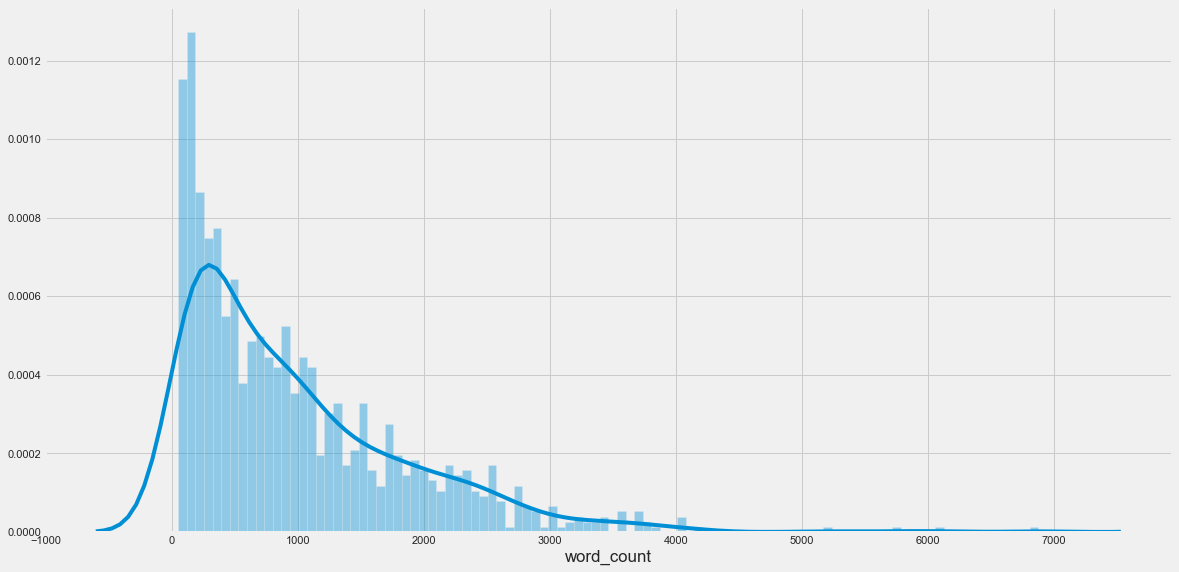

In [51]:
tmp_speech_df.reset_index(drop=True, inplace=True)
add_word_count(tmp_speech_df)
sns.distplot(tmp_speech_df["word_count"], bins=100)

In [52]:
tmp_speech_df.loc[tmp_speech_df['word_count'] > 5000]

,type,text,date,speaker,org_contents,target,rate,word_count,text_sections
29,speech,\n\nThe Analytical Framework\r\nLet me remind you at the outset of the framework I have been using to explain the challenge facing monetary policy in the current environment of healthy growth and ...,1997-04-24,Governor Laurence H. Meyer,\n\n[SECTION]\n\nThe Economic Outlook and Challenges Facing Monetary Policy\n\n[SECTION]\n\nIt is a pleasure to be here and discuss the economic outlook and monetary policy with fellow forecasters...,0.0,5.25,5194,"[\n\n, \n\nThe Economic Outlook and Challenges Facing Monetary Policy\n\n, \n\nIt is a pleasure to be here and discuss the economic outlook and monetary policy with fellow forecasters. I am going..."
139,speech,"\n\nThen I will turn to the new challenges for monetary policy identified at the conference. Each is illustrated by current or recent experience around the world. First, does a low-inflation env...",1999-10-12,Governor Laurence H. Meyer,"\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\n\n\n[SECTION]\n\nNew Challenges for Monetary Policy: The View from Jackson Hole\n\n[SECTION]\n\nEach year in late August, for the last 23 years, ...",2.0,5.50,5745,"[\n\n, \n\n\n\n, \n\n\n\n, \n\n\n\n, \n\nNew Challenges for Monetary Policy: The View from Jackson Hole\n\n, \n\nEach year in late August, for the last 23 years, the Federal Reserve Bank of Kansas..."
211,speech,"\n\nClassical macroeconomics emphasized several key long-run properties of the economy, including the neutrality of money and the quantity theory of money. Neutrality holds if the equilibrium val...",2001-03-28,Governor Laurence H. Meyer,Does Money Matter?\n\n[SECTION]\n\nIt is always a pleasure to return to St. Louis and to Washington University and to see so many friends and former colleagues. But it is a special pleasure to be...,0.0,4.50,6106,"[Does Money Matter?\n\n, \n\nIt is always a pleasure to return to St. Louis and to Washington University and to see so many friends and former colleagues. But it is a special pleasure to be here ..."
245,speech,"\n\nAlthough the Taylor rule has been a useful benchmark for policymakers, my experience during the last 5-1/2 years on the FOMC has been that considerations that are not explicit in the Taylor ru...",2002-01-16,Governor Laurence H. Meyer,Rules and Discretion\n\n[SECTION]\n\nAn extensive literature addresses the question of whether it is preferable to implement monetary policy by a rule or by discretion. This question has traditio...,1.0,1.75,6876,"[Rules and Discretion\n\n, \n\nAn extensive literature addresses the question of whether it is preferable to implement monetary policy by a rule or by discretion. This question has traditionally ..."


In [53]:
#print(tmp_speech_df.iloc[29].text)
for i, row in tmp_speech_df.iterrows():
    print(row.date, row.speaker)

1996-06-13 00:00:00 Chairman Alan Greenspan
1996-06-18 00:00:00 Governor Edward W. Kelley, Jr.
1996-09-08 00:00:00 Governor Laurence H. Meyer
1996-09-19 00:00:00 Chairman Alan Greenspan
1996-10-02 00:00:00 Governor Lawrence B. Lindsey
1996-10-05 00:00:00 Chairman Alan Greenspan
1996-10-07 00:00:00 Chairman Alan Greenspan
1996-10-09 00:00:00 Governor Lawrence B. Lindsey
1996-10-11 00:00:00 Governor Lawrence B. Lindsey
1996-10-31 00:00:00 Governor Susan M. Phillips
1996-11-18 00:00:00 Chairman Alan Greenspan
1996-11-21 00:00:00 Governor Laurence H. Meyer
1996-11-25 00:00:00 Governor Susan M. Phillips
1996-12-05 00:00:00 Chairman Alan Greenspan
1996-12-06 00:00:00 Chairman Alan Greenspan
1996-12-19 00:00:00 Vice Chair Alice M. Rivlin
1997-01-05 00:00:00 Governor Laurence H. Meyer
1997-01-14 00:00:00 Chairman Alan Greenspan
1997-01-16 00:00:00 Governor Laurence H. Meyer
1997-01-28 00:00:00 Governor Susan M. Phillips
1997-01-29 00:00:00 Governor Edward W. Kelley, Jr.
1997-02-14 00:00:00 Gov

2005-03-11 00:00:00 Chairman Alan Greenspan
2005-03-18 00:00:00 Chairman Alan Greenspan
2005-03-30 00:00:00 Governor Ben S. Bernanke
2005-04-05 00:00:00 Chairman Alan Greenspan
2005-04-08 00:00:00 Chairman Alan Greenspan
2005-04-14 00:00:00 Governor Donald L. Kohn
2005-04-14 00:00:00 Governor Ben S. Bernanke
2005-04-18 00:00:00 Governor Susan Schmidt Bies
2005-04-20 00:00:00 Vice Chairman Roger W. Ferguson, Jr.
2005-04-21 00:00:00 Governor Edward M. Gramlich
2005-04-22 00:00:00 Governor Donald L. Kohn
2005-04-27 00:00:00 Vice Chairman Roger W. Ferguson, Jr.
2005-05-05 00:00:00 Chairman Alan Greenspan
2005-05-12 00:00:00 Vice Chairman Roger W. Ferguson, Jr.
2005-05-19 00:00:00 Chairman Alan Greenspan
2005-05-20 00:00:00 Governor Donald L. Kohn
2005-05-20 00:00:00 Chairman Alan Greenspan
2005-05-26 00:00:00 Governor Edward M. Gramlich
2005-05-27 00:00:00 Vice Chairman Roger W. Ferguson, Jr.
2005-06-03 00:00:00 Governor Edward M. Gramlich
2005-06-03 00:00:00 Governor Mark W. Olson
2005-06

2008-02-26 00:00:00 Vice Chairman Donald L. Kohn
2008-02-29 00:00:00 Governor Frederic S. Mishkin
2008-03-03 00:00:00 Governor Randall S. Kroszner
2008-03-04 00:00:00 Chairman Ben S. Bernanke
2008-03-04 00:00:00 Vice Chairman Donald L. Kohn
2008-03-07 00:00:00 Governor Frederic S. Mishkin
2008-03-07 00:00:00 Governor Frederic S. Mishkin
2008-03-14 00:00:00 Chairman Ben S. Bernanke
2008-03-27 00:00:00 Governor Randall S. Kroszner
2008-03-27 00:00:00 Governor Frederic S. Mishkin
2008-04-03 00:00:00 Governor Frederic S. Mishkin
2008-04-04 00:00:00 Governor Randall S. Kroszner
2008-04-10 00:00:00 Chairman Ben S. Bernanke
2008-04-14 00:00:00 Governor Kevin Warsh
2008-04-17 00:00:00 Vice Chairman Donald L. Kohn
2008-04-21 00:00:00 Governor Randall S. Kroszner
2008-05-05 00:00:00 Chairman Ben S. Bernanke
2008-05-07 00:00:00 Governor Randall S. Kroszner
2008-05-13 00:00:00 Chairman Ben S. Bernanke
2008-05-13 00:00:00 
2008-05-15 00:00:00 Chairman Ben S. Bernanke
2008-05-15 00:00:00 Vice Chairm

2019-09-26 00:00:00 Vice Chair Richard H. Clarida
2019-09-27 00:00:00 Vice Chair for Supervision Randal K. Quarles
2019-10-01 00:00:00 Governor Michelle W. Bowman
2019-10-04 00:00:00 Chair Jerome H. Powell
2019-10-07 00:00:00 Chair Jerome H. Powell
2019-10-08 00:00:00 Chair Jerome H. Powell
2019-10-09 00:00:00 Chair Jerome H. Powell
2019-10-16 00:00:00 Governor Lael Brainard
2019-10-17 00:00:00 Governor Michelle W. Bowman
2019-10-18 00:00:00 Vice Chair Richard H. Clarida
2019-11-01 00:00:00 Vice Chair for Supervision Randal K. Quarles
2019-11-01 00:00:00 Vice Chair Richard H. Clarida
2019-11-08 00:00:00 Governor Lael Brainard
2019-11-12 00:00:00 Vice Chair Richard H. Clarida
2019-11-14 00:00:00 Vice Chair Richard H. Clarida
2019-11-25 00:00:00 Chair Jerome H. Powell
2019-11-26 00:00:00 Governor Lael Brainard
2019-12-18 00:00:00 Governor Lael Brainard
2020-01-09 00:00:00 Governor Michelle W. Bowman
2020-01-16 00:00:00 Vice Chair Richard H. Clarida


In [54]:
speech_df.loc[speech_df.index == '2009-08-21']

,contents,speaker,title
Date,,,
2009-08-21,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",Chairman Ben S. Bernanke,Reflections on a Year of Crisis
2009-08-21,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...","Brian F. Madigan, Director, Division of Monetary Affairs",Bagehot's Dictum in Practice: Formulating and Implementing Policies to Combat the Financial Crisis
2009-08-21,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",,Reflections on a Year of Crisis


In [55]:
print(len(tmp_speech_df))
tmp_speech_df.loc[tmp_speech_df['speaker']=='']

1117


,type,text,date,speaker,org_contents,target,rate,word_count,text_sections
643,speech,"\n\nAnd what are the terms at which the central bank should lend freely? Bagehot argues that ""these loans should only be made at a very high rate of interest"" (p. 99). Some modern commentators hav...",2008-05-13,,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",1.0,2.00,739,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n, \n\nFederal Open Market Committee\n\n, \n\nMo..."
704,speech,"\n\nSeptember-October 2008: The Crisis IntensifiesWhen we met last year, financial markets and the economy were continuing to suffer the effects of the ongoing crisis. We know now that the Nationa...",2009-08-21,,"The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n[SECTION]\n\nFederal Open Market Committee\n\n[S...",1.0,0.25,1125,"[The Federal Reserve, the central bank of the United States, provides the nation with a safe, flexible, and stable monetary and financial system.\n\n, \n\nFederal Open Market Committee\n\n, \n\nMo..."


In [56]:
tmp_speech_df.drop([643,704], axis=0, inplace=True)

In [57]:
print(len(tmp_speech_df))
tmp_speech_df.loc[tmp_speech_df['speaker']=='']

1115


,type,text,date,speaker,org_contents,target,rate,word_count,text_sections


In [58]:
remove_return_code(tmp_speech_df)

In [59]:
speech_greenspan = tmp_speech_df[tmp_speech_df['speaker'].str.contains("GREENSPAN|Greenspan|greenspan")]
speech_greenspan['speaker'] = 'Alan Greenspan'

speech_bernanke = tmp_speech_df[tmp_speech_df['speaker'].str.contains("BERNANKE|Bernanke|bernanke")]
speech_bernanke['speaker'] = 'Ben Bernanke'

speech_yellen = tmp_speech_df[tmp_speech_df['speaker'].str.contains("YELLEN|Yellen|yellen")]
speech_yellen['speaker'] = 'Janet Yellen'

speech_powell = tmp_speech_df[tmp_speech_df['speaker'].str.contains("POWELL|Powell|powell")]
speech_powell['speaker'] = 'Jerome Powell'

speech_gbyp_df = pd.concat([speech_greenspan, speech_bernanke, speech_yellen, speech_powell], ignore_index=True)

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http:

In [60]:
speech_gbyp_df.shape

(421, 9)

### Split contents to max 200 words

In [61]:
speech_split_df = get_split_df(speech_gbyp_df)
speech_split_df.tail()

,speaker,text,target,rate,date,type
2653,Jerome Powell,"a setting below r* would tend to speed up the economy. A second benchmark is the natural rate of unemployment, which is the lowest rate of unemployment that would not create upward pressure on inf...",1.0,1.75,2019-11-25,speech
2654,Jerome Powell,"u*.4 Taken at face value, a lower r* would suggest that monetary policy is providing somewhat less support for employment and inflation than previously believed, and the fall in u* would suggest t...",1.0,1.75,2019-11-25,speech
2655,Jerome Powell,"range for the federal funds rate by 3/4 percentage point. The full effects of these monetary policy actions will be felt over time, but we believe they are already helping to support consumer and ...",1.0,1.75,2019-11-25,speech
2656,Jerome Powell,"Sustained Return of Inflation to 2 percentFor many years as the economy recovered from the Great Recession, inflation averaged around 1.5 percentâbelow our 2 percent objective (figure 3). We had...",1.0,1.75,2019-11-25,speech
2657,Jerome Powell,rates. That is why it is essential that we at the Fed use our tools to make sure that we do not permit an unhealthy downward drift in inflation expectations and inflation. We are strongly committe...,1.0,1.75,2019-11-25,speech


In [62]:
speech_split_df.shape

(2658, 6)

## Combine DataFrames and Save

### All Data, before splitting

In [63]:
frames = [statement_df, minutes_df, script_speaker_df, tmp_speech_df]

df = pd.concat(frames, sort=True)
one_hot_encode(df)
df.reset_index(inplace=True, drop=True)
df.drop(columns=['text_sections', 'org_contents'], inplace=True)
df.rename(columns={'contents': 'text'}, inplace=True)

print(df.shape)
df.head(10)

(3042, 10)


,date,rate,speaker,target,text,type,word_count,target_lower,target_hold,target_raise
0,1994-02-04,3.25,Alan Greenspan,2,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated wi...,statement,99,0,0,1
1,1994-03-22,3.5,Alan Greenspan,2,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated w...,statement,40,0,0,1
2,1994-04-18,3.75,Alan Greenspan,2,Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase...,statement,37,0,0,1
3,1994-05-17,4.25,Alan Greenspan,2,"In taking the discount action, the Board approved requests submitted by the Boards of Directors of eleven Federal Reserve Banks -- Boston, New York, Philadelphia, Richmond, Atlanta, Chicago, St. ...",statement,57,0,0,1
4,1994-08-16,4.75,Alan Greenspan,2,"In taking the discount rate action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Kansas City, and Dallas. The disco...",statement,51,0,0,1
5,1994-11-15,5.5,Alan Greenspan,2,"In a related move, the Federal Open Market Committee decided that the increase in the discount rate should be reflected fully in interest rates in reserve markets. These measures were taken again...",statement,121,0,0,1
6,1995-02-01,6,Alan Greenspan,2,"In taking the discount action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Chicago, St. Louis, Kansas City and San...",statement,54,0,0,1
7,1995-07-06,5.75,Alan Greenspan,0,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on bank reserve positions. As a result of the monetary tightenin...,statement,67,1,0,0
8,1995-12-19,5.5,Alan Greenspan,0,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to decrease slightly the degree of pressure on reserve positions. Since the last easing of monetary policy i...,statement,81,1,0,0
9,1996-01-31,5.25,Alan Greenspan,0,"The Federal Reserve today announced the following policy actions:The Board of Governors approved a reduction in the discount rate from 5-1/4 percent to 5 percent, effective immediately.In a relat...",statement,101,1,0,0


In [64]:
with open("../data/FOMC/train_all_df.pickle", "wb") as file:
    pickle.dump(df, file)

# In case pickle is not available
df.to_csv('../data/FOMC/train_all_df.csv', index=True)

### Take chairpersons speaking, before splitting

In [65]:
speaker_frames = [statement_df, minutes_df, script_gbyp_combined_df, speech_gbyp_df]

speaker_df = pd.concat(speaker_frames, sort=True)
one_hot_encode(speaker_df)
speaker_df.reset_index(inplace=True, drop=True)
speaker_df.drop(columns=['text_sections', 'org_contents'], inplace=True)
speaker_df.rename(columns={'contents': 'text'}, inplace=True)

print(speaker_df.shape)
speaker_df.tail()

(869, 10)


,date,rate,speaker,target,text,type,word_count,target_lower,target_hold,target_raise
864,2019-10-04,2,Jerome Powell,1,"Now is a good time to conduct the review. Unemployment is near a half-century low, and inflation is running close to, but a bit below, our 2 percent objective. While not everyone fully shares econ...",speech,264,0,1,0
865,2019-10-07,2,Jerome Powell,1,"During World War II, the Fed effectively ceded control of monetary policy to the Treasury Department by agreeing to maintain a low interest rate peg on government bonds. The low rates helped the g...",speech,115,0,1,0
866,2019-10-08,2,Jerome Powell,1,"The advance of technology has long presented measurement challenges. In 1987, Nobel Prizeâwinning economist Robert Solow quipped that ""you can see the computer age everywhere but in the producti...",speech,887,0,1,0
867,2019-10-09,2,Jerome Powell,1,"Now is a good time to conduct the review. Unemployment is at a half-century low, and inflation is running close to, but a bit below, our 2 percent objective. While not everyone fully shares econom...",speech,264,0,1,0
868,2019-11-25,1.75,Jerome Powell,1,"These themes show through in many ways in official statistics. For example, more than a decade of steady advances has pushed the jobless rate near a 50-year low, where it has remained for well ove...",speech,1010,0,1,0


In [66]:
with open("../data/FOMC/train_speaker_df.pickle", "wb") as file:
    pickle.dump(speaker_df, file)

# In case pickle is not available
speaker_df.to_csv('../data/FOMC/train_speaker_df.csv', index=True)

### Split statement, scripts and speech by chairperson only
Do not use minutes for now.

In [67]:
split_frame = [stmt_split_df, minutes_split_df, script_split_df, speech_split_df]

split_df = pd.concat(split_frame, ignore_index=True, sort=True)
one_hot_encode(split_df)
split_df['target'] = split_df['target'].map(lambda x: int(x))
add_word_count(split_df)
#split_df.rename(columns={'contents': 'text'}, inplace=True)

print(split_df.shape)
split_df.head()

/Users/yuki/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.



(8462, 10)


,date,rate,speaker,target,text,type,target_lower,target_hold,target_raise,word_count
0,1994-02-04,3.25,Alan Greenspan,2,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. The action is expected to be associated wit...,statement,0,0,1,99
1,1994-03-22,3.50,Alan Greenspan,2,Chairman Alan Greenspan announced today that the Federal Open Market Committee decided to increase slightly the degree of pressure on reserve positions. This action is expected to be associated wi...,statement,0,0,1,40
2,1994-04-18,3.75,Alan Greenspan,2,Chairman Alan Greenspan announced today that the Federal Reserve will increase slightly the degree of pressure on reserve positions. This action is expected to be associated with a small increase ...,statement,0,0,1,37
3,1994-05-17,4.25,Alan Greenspan,2,"In taking the discount action, the Board approved requests submitted by the Boards of Directors of eleven Federal Reserve Banks -- Boston, New York, Philadelphia, Richmond, Atlanta, Chicago, St. L...",statement,0,0,1,57
4,1994-08-16,4.75,Alan Greenspan,2,"In taking the discount rate action, the Board approved requests submitted by the Boards of Directors of the Federal Reserve Banks of Boston, New York, Richmond, Kansas City, and Dallas. The discou...",statement,0,0,1,51


In [68]:
with open("../data/FOMC/train_split_df.pickle", "wb") as file:
    pickle.dump(split_df, file)

# In case pickle is not available
split_df.to_csv('../data/FOMC/train_split_df.csv', index=True)

In [69]:
print(split_df.shape)

(8462, 10)


In [70]:
print(split_df['type'].value_counts())

minutes      3871
speech       2658
script       1590
statement     343
Name: type, dtype: int64


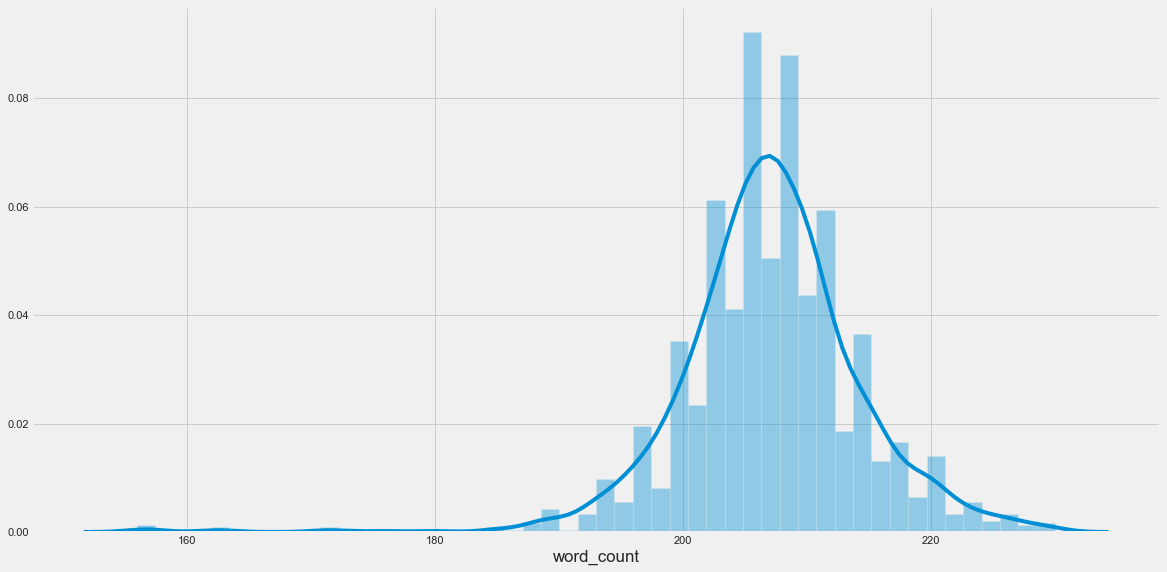

In [73]:
sns.distplot(split_df.loc[split_df['type']=='script']["word_count"])

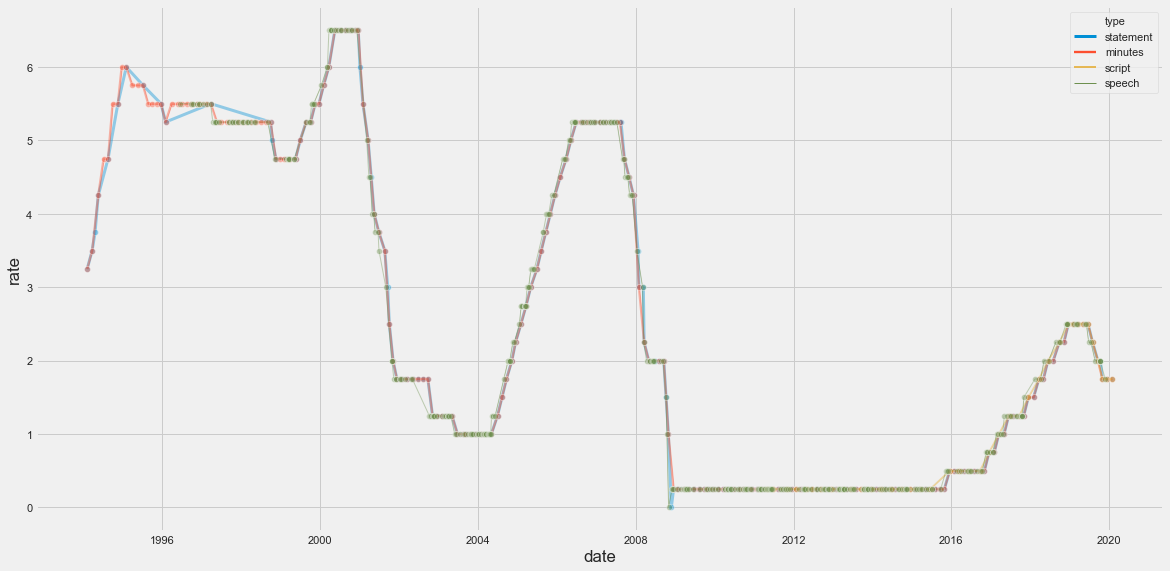

In [89]:
sns.lineplot(y=split_df["rate"].apply(lambda x: float(x)), 
             x=split_df['date'], 
             hue=split_df['type'], 
             hue_order=['statement', 'minutes', 'script', 'speech'], 
             size=split_df['type'], 
             sizes=(1, 3), 
             alpha=0.4,
             marker='o')

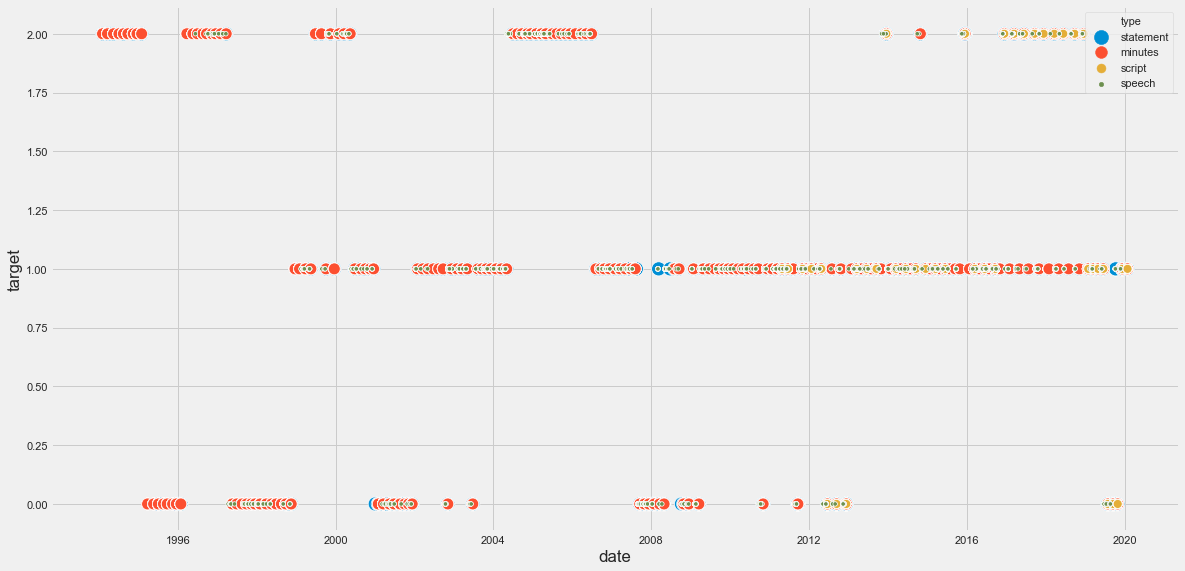

In [90]:
sns.scatterplot(y=split_df["target"].apply(lambda x: float(x)), 
                x=split_df['date'], 
                hue=split_df['type'], 
                hue_order=['statement', 'minutes', 'script', 'speech'], 
                size=split_df['type'], 
                sizes=(20, 200))